In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#importing the raw data
rawdata = pd.read_csv("datam.csv", low_memory=False)
#filtering out the data which has stability meansurement of T80
data = rawdata.loc[pd.to_numeric(rawdata['JV_hysteresis_index'], errors='coerce').notnull()]
data = data.loc[pd.to_numeric(rawdata['TS80m'], errors='coerce').notnull()]
data = data[~data.apply(lambda row: row.astype(str).str.contains('ISOS-L').any(), axis=1)]

data.to_excel('Dark Stability_data.xlsx')
display(data.columns.tolist())

In [13]:
print(data.shape)

(1567, 414)


In [5]:
#preprocession of categorical variables
cat_vars = ['Cell_architecture','Cell_stack_sequence','ETL_deposition_procedure','Perovskite_composition_a_ions',
           'Perovskite_composition_c_ions','HTL_stack_sequence','Backcontact_stack_sequence','Perovskite_deposition_solvents','Substrate_stack_sequence']
jv =['JV_reverse_scan_Voc','JV_reverse_scan_Jsc','JV_reverse_scan_FF', 'JV_reverse_scan_PCE'
,'JV_forward_scan_Voc',	'JV_forward_scan_Jsc',	'JV_forward_scan_FF',	'JV_forward_scan_PCE'
]
jvdata=pd.DataFrame(data[jv])
#print(jvdata)
encoder=OneHotEncoder()
cat_data = encoder.fit_transform(data[cat_vars])
cat_column_names = encoder.get_feature_names_out()
#display(cat_data)

catdata = pd.DataFrame(cat_data.toarray(), columns = cat_column_names)
catdata.reset_index(drop=True, inplace = True)
stadata = pd.DataFrame(data['TS80m'])
stadata.reset_index(drop=True, inplace=True)
jvdata.reset_index(drop=True,inplace=True)
fdata = pd.concat([catdata,jvdata, stadata], axis=1)


#print(fdata.shape)


fdata.to_excel('Dark formatted data for stablity.xlsx')

In [2]:
fdata = pd.read_excel('Dark formatted data for stablity.xlsx')
fdata = fdata.drop(columns=['Unnamed: 0'], axis=1)
print(fdata.shape)

(1567, 1183)


In [3]:
#fdata = fdata.drop(columns=['Unnamed: 0'])
#seggregating label and features
x,y = fdata.drop(columns=['TS80m']), fdata['TS80m']

#splitting the data into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test = train_test_split(x,y, test_size = 0.15, random_state = 42,shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train, test_size = 0.4, random_state=42)

In [4]:
#print(fdata.columns)
print(fdata.shape)
print(x.shape, y.shape)

(1567, 1183)
(1567, 1182) (1567,)


In [17]:
from sklearn.ensemble import RandomForestRegressor

# Assuming 'X' is your feature matrix and 'y' is your target variable
model = RandomForestRegressor()
model.fit(x, y)

# Get feature importances
feature_importances = model.feature_importances_

# Select top N features with highest importance scores
top_features = x.columns[np.argsort(feature_importances)[::-1][:50]].tolist()


In [16]:
#print(top_features)
coTs = fdata.corrwith(fdata['TS80m'])
Correlations =pd.DataFrame()
Correlations = pd.DataFrame(coTs)
display(Correlations)
Correlations.to_excel('Correlationsrl.xlsx', index=True)

,0
Cell_architecture_Back contacted,-0.002492
Cell_architecture_nip,-0.014280
Cell_architecture_pin,0.014431
Cell_stack_sequence_A.R.C. | SLG | FTO | TiO2-c | TiO2-mp | Perovskite | Spiro-MeOTAD | Au,-0.004669
Cell_stack_sequence_Au | 4-methoxythiophenol | Perovskite | 4-chlorothiophenol | Au,-0.002492
...,...
JV_forward_scan_Voc,0.107279
JV_forward_scan_Jsc,-0.067314
JV_forward_scan_FF,0.024772
JV_forward_scan_PCE,-0.006972


In [18]:
print(coTs.shape)

(1183,)


In [7]:
from sklearn.ensemble import RandomForestRegressor
modelRF = RandomForestRegressor(n_estimators=2000, max_depth=1180, random_state=42)
modelRF.fit(X_train, Y_train)
print(modelRF.score)

<bound method RegressorMixin.score of RandomForestRegressor(max_depth=1180, n_estimators=2000, random_state=42)>


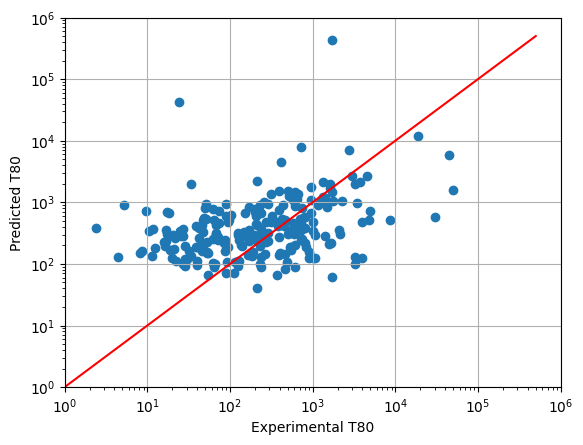

In [8]:
y_predictedRF = modelRF.predict(x_test)
plt.scatter(y_test,y_predictedRF)
xt = [0,500000]
yt = [0,500000]
plt.plot(xt,yt, color = 'r')
plt.xlabel('Experimental T80')
plt.ylabel('Predicted T80')
plt.xlim(1,10**6)
plt.ylim(1,10**6)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.savefig('Figure_7', dpi=600, format='png')

In [27]:
import numpy as np

def rmse(y_true, y_pred):
    """
    Calculate the Root Mean Square Error (RMSE) between actual and predicted values.
    
    Parameters:
    y_true (array-like): Actual values.
    y_pred (array-like): Predicted values.
    
    Returns:
    float: RMSE value.
    """
    return np.sqrt(np.mean((y_true - y_pred) ** 2))
print(rmse(y_predictedRF,y_test))

28982.78559573201


In [21]:
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)




# Create a sequential model
modelNN = models.Sequential()

# Add an input layer with 1310 variables
modelNN.add(layers.InputLayer(input_shape=(1183)))

# Add hidden layers
#modelNN.add(layers.Dense(2048, activation='relu'))
modelNN.add(layers.Dense(1024, activation='relu'))
#modelNN.add(layers.Dense(512, activation='relu'))
modelNN.add(layers.Dense(252, activation='relu'))
#modelNN.add(layers.Dense(128, activation='relu'))
modelNN.add(layers.Dense(64, activation='relu'))
modelNN.add(layers.Dense(32, activation='relu'))

# Add the output layer with one neuron (for regression)
modelNN.add(layers.Dense(1))

# Compile the model
modelNN.compile(optimizer='RMSprop', loss='mean_squared_error', metrics=['mae'])

# Define a ModelCheckpoint callback

model_checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',  # Change monitor to 'val_accuracy'
    save_best_only=True,
    save_weights_only=False,
    mode='min',  # Use 'max' for accuracy
    verbose=1
)


In [22]:
history = modelNN.fit(x_train, y_train, epochs=500, batch_size=64, validation_data=(x_val, y_val), callbacks=[model_checkpoint])


Epoch 1/500
11/13 [========================>.....] - ETA: 0s - loss: 243717072.0000 - mae: 2461.9768
Epoch 1: val_loss improved from inf to 879126976.00000, saving model to best_model.h5
13/13 [==============================] - 4s 65ms/step - loss: 221424896.0000 - mae: 2477.0029 - val_loss: 879126976.0000 - val_mae: 2822.5542
Epoch 2/500
 8/13 [=================>............] - ETA: 0s - loss: 312586080.0000 - mae: 3434.2913
Epoch 2: val_loss did not improve from 879126976.00000
13/13 [==============================] - 0s 12ms/step - loss: 219560048.0000 - mae: 3066.2190 - val_loss: 879380736.0000 - val_mae: 2742.5090
Epoch 3/500
 8/13 [=================>............] - ETA: 0s - loss: 86377840.0000 - mae: 2332.0188
Epoch 3: val_loss improved from 879126976.00000 to 878458304.00000, saving model to best_model.h5
13/13 [==============================] - 0s 14ms/step - loss: 219159536.0000 - mae: 2874.3931 - val_loss: 878458304.0000 - val_mae: 3131.8777
Epoch 4/500
 9/13 [==============

8/8 [==============================] - 0s 1ms/step


NameError: name 'xt' is not defined

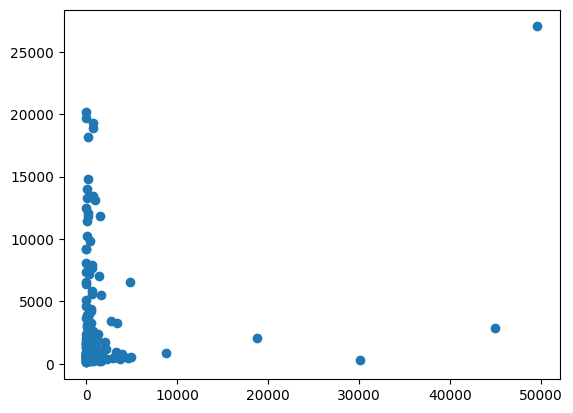

In [23]:
from tensorflow.keras.models import load_model
bestmodelNN = load_model('best_model.h5')
ypredictNN = bestmodelNN.predict(x_test)
plt.scatter(y_test,ypredictNN)
plt.plot(xt,yt)
plt.xlim(-1000,7000)
plt.ylim(-1000,7000)
plt.xlabel('Experimental T80')
plt.ylabel('Predicted T80')
plt.title('Neural Network')
plt.grid()

In [ ]:
ypnn = ypredictNN.flatten()
print(np.sum(np.square(y_test-ypnn))**0.5)

In [ ]:
'''from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 40, 60, 80, 90],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6, 8],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# Create a base model
rfm = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
'''

In [ ]:
print(best_params)

In [ ]:
rffinal =  RandomForestRegressor(n_estimators=500,max_depth=60,min_samples_leaf=2,min_samples_split=10)
rffinal.fit(x_train,y_train)

In [ ]:
ypredicted_RF = rffinal.predict(x_test)

In [ ]:
plt.scatter(y_test,ypredicted_RF)
plt.grid()
xt = [0,7000]
yt = [0,7000]
plt.plot(xt,yt)
plt.xlim(0,7000)
plt.ylim(0,7000)
plt.xlabel('Experimental T80')
plt.ylabel('Predicted T80')
plt.title('RandomForestRegressor')

In [ ]:
print(np.sum(np.square(y_test-ypredicted_RF))**0.5)

In [ ]:
bestmodelNN.summary()